In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install Pillow

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import time
from IPython import display

In [ ]:
print(tf.version.VERSION)

2.15.0


In [ ]:
foreset_fire_data_dir = '/content/drive/MyDrive/GANs vs Diffusion/data/fire_250'

In [ ]:
train_images = tf.keras.utils.image_dataset_from_directory(
    foreset_fire_data_dir, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 950 files belonging to 1 classes.


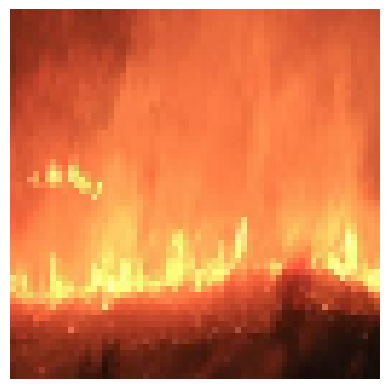

In [ ]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [ ]:
## Preprocessing

In [ ]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 100
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [ ]:
def build_generator():
    # create a Keras Sequential model
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                              

In [ ]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.d_loss_array = []
        self.g_loss_array = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.d_loss_array = []  # To store discriminator losses
        self.g_loss_array = []  # To store generator losses
        self.epoch_counter = 0

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    # def on_epoch_end(self, epoch, logs=None):
    #     generated_images = self.model.generator(self.seed)
    #     generated_images = (generated_images * 127.5) + 127.5
    #     generated_images.numpy()

    #     if logs is not None:
    #         self.d_loss_array.append(logs.get('d_loss'))
    #         self.g_loss_array.append(logs.get('g_loss'))

    #     fig = plt.figure(figsize=(8, 8))
    #     for i in range(self.num_img):
    #         plt.subplot(4, 4, i+1)
    #         img = keras.utils.array_to_img(generated_images[i])
    #         plt.imshow(img)
    #         plt.axis('off')
    #     plt.savefig('epoch_{:03d}.png'.format(epoch))
    #     # plt.show()


    def on_epoch_end(self, epoch, logs=None):

        if logs is not None:
            self.d_loss_array.append(logs.get('d_loss'))
            self.g_loss_array.append(logs.get('g_loss'))

        self.epoch_counter += 1
        if self.epoch_counter % 100 == 0:  # Save images every 20 epochs
            generated_images = self.model.generator(self.seed)
            generated_images = (generated_images * 127.5) + 127.5
            generated_images.numpy()

            fig = plt.figure(figsize=(8, 8))
            for i in range(self.num_img):
                plt.subplot(4, 4, i+1)
                img = keras.utils.array_to_img(generated_images[i])
                plt.imshow(img)
                plt.axis('off')
            plt.savefig('epoch_{:03d}.png'.format(epoch))
            plt.close()
        if self.epoch_counter % 100 == 0:  # Save images every 100 epochs
            generated_images = self.model.generator(tf.random.normal([500, self.latent_dim]))
            generated_images = (generated_images * 127.5) + 127.5
            generated_images.numpy()
            output_dir = "generated_images_"+str(self.epoch_counter)

            os.makedirs(output_dir, exist_ok=True)
            for i, img_array in enumerate(generated_images):

                generated_images = (generated_images * 127.5) + 127.5
                generated_images.numpy()

                # Convert the image array to uint8
                img_array = tf.cast(img_array, tf.uint8)
                # Encode image to PNG format
                img = tf.image.encode_png(img_array)
                # print(img)
                # Write the PNG image to a file
                img_path = os.path.join(output_dir, f"generated_image_{i}.png")
                tf.io.write_file(img_path, img)


    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')
        # Plotting loss curves
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_loss_array, label="Discriminator Loss")
        plt.plot(self.g_loss_array, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig('loss_curves.png')
        plt.show()

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

30/30 [==============================] - 3s 86ms/step - d_loss: 0.3622 - g_loss: 1.7122
Epoch 796/801
30/30 [==============================] - 3s 87ms/step - d_loss: 0.3401 - g_loss: 1.8107
Epoch 797/801
30/30 [==============================] - 4s 108ms/step - d_loss: 0.3557 - g_loss: 1.6691
Epoch 798/801
30/30 [==============================] - 3s 87ms/step - d_loss: 0.3384 - g_loss: 1.7371
Epoch 799/801
30/30 [==============================] - 3s 85ms/step - d_loss: 0.3577 - g_loss: 1.7718
Epoch 800/801
30/30 [==============================] - 20s 667ms/step - d_loss: 0.3437 - g_loss: 1.7781
Epoch 801/801
30/30 [==============================] - 3s 82ms/step - d_loss: 0.3421 - g_loss: 1.7664


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


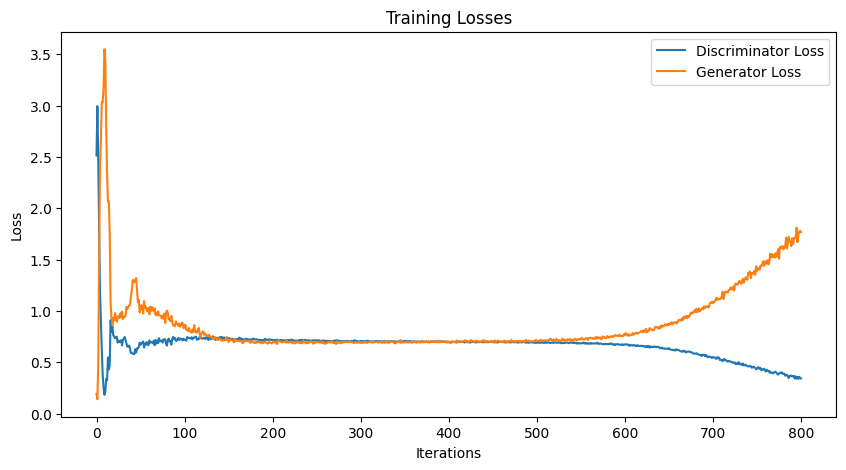

In [ ]:
NUM_EPOCHS = 801 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

In [ ]:
dcgan.d_loss_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.3420649>

In [ ]:
input_seeed = tf.random.normal([500, 100])

In [ ]:
input_seeed.shape

TensorShape([500, 100])

In [ ]:

new_model = tf.keras.models.load_model('generator.h5')

In [ ]:
new_model.summary()

In [ ]:
fig = plt.figure(figsize=(8, 8))
for i in range(self.num_img):
    plt.subplot(4, 4, i+1)
    img = keras.utils.array_to_img(generated_images[i])
    plt.imshow(img)
    plt.axis('off')
plt.savefig('epoch_{:03d}.png'.format(epoch))
plt.close()

In [ ]:
dcgan.d_loss_array[2]

In [ ]:
 self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

In [ ]:
!zip -r /content/epoch_output_images.zip /content/*.png

!rsync -r --progress "./epoch_output_images.zip" "/content/drive/My Drive/GAN/forest_fire_epoch_images"

  adding: content/epoch_099.png (deflated 1%)
  adding: content/epoch_199.png (deflated 1%)
  adding: content/epoch_299.png (deflated 1%)
  adding: content/epoch_399.png (deflated 1%)
  adding: content/epoch_499.png (deflated 1%)
  adding: content/epoch_599.png (deflated 1%)
  adding: content/epoch_699.png (deflated 1%)
  adding: content/epoch_799.png (deflated 1%)
  adding: content/loss_curves.png (deflated 8%)
sending incremental file list
epoch_output_images.zip
      4,139,712 100%  217.59MB/s    0:00:00 (xfr#1, to-chk=0/1)


In [ ]:
epoch_list = [100,200,300,400,500,600,700,800]

In [ ]:
!zip -r /content/generated_images_200.zip /content/generated_images_200

!rsync -r --progress "./generated_images_200.zip" "/content/drive/My Drive/GAN/generated_images_200"

In [ ]:
!zip -r /content/generated_images_300.zip /content/generated_images_300

!rsync -r --progress "./generated_images_300.zip" "/content/drive/My Drive/GAN/generated_images_300"

In [ ]:
!zip -r /content/generated_images_400.zip /content/generated_images_400

!rsync -r --progress "./generated_images_400.zip" "/content/drive/My Drive/GAN/generated_images_400"

In [ ]:
!zip -r /content/generated_images_500.zip /content/generated_images_500

!rsync -r --progress "./generated_images_500.zip" "/content/drive/My Drive/GAN/generated_images_500"

In [ ]:
!zip -r /content/generated_images_600.zip /content/generated_images_600

!rsync -r --progress "./generated_images_600.zip" "/content/drive/My Drive/GAN/generated_images_600"

In [ ]:
!zip -r /content/generated_images_700.zip /content/generated_images_700

!rsync -r --progress "./generated_images_700.zip" "/content/drive/My Drive/GAN/generated_images_700"

In [ ]:
!zip -r /content/generated_images_800.zip /content/generated_images_800

!rsync -r --progress "./generated_images_800.zip" "/content/drive/My Drive/GAN/generated_images_800"

In [ ]:
!rsync -r --progress "./generator.h5" "/content/drive/My Drive/GAN/dcgan_color/"

sending incremental file list
created directory /content/drive/My Drive/GAN/dcgan_color
generator.h5
     24,292,768 100%  282.15MB/s    0:00:00 (xfr#1, to-chk=0/1)


In [ ]:
import glob

In [ ]:
all_images_list = []
for i in range(1,1000):
  all_images_list.append('epoch_{:03d}.png'.format(i))

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os

def add_text_to_image(image, text):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    text_width, text_height = draw.textsize(text, font)
    position = (image.width - text_width, 0)
    draw.text(position, text, fill='black', font=font)

In [ ]:
image_list = []
for file_name in all_images_list:
  image = Image.open(file_name)
  add_text_to_image(image, file_name)
  image_list.append(image)

In [ ]:
# Save the first image as a GIF file
image_list[0].save(
            'animation_faster.gif',
            save_all=True,
            append_images=image_list[1:], # append rest of the images
            duration=300, # in milliseconds
            loop=0)

In [ ]:
!rsync -r --progress "./animation_faster.gif" "/content/drive/My Drive/GAN/"